In [1]:
import helpsk as hlp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline

# Load Data

In [2]:
#https://www.openml.org/d/31
credit_g = fetch_openml('credit-g', version=1)
credit_data = credit_g['data']
credit_data['target'] = credit_g['target']
credit_data.shape

(1000, 21)

In [3]:
## Create Missing Values
credit_data['duration'].iloc[0:46] = np.nan
credit_data['checking_status'].iloc[25:75] = np.nan
credit_data['credit_amount'].iloc[10:54] = 0

/Users/shanekercheval/opt/anaconda3/envs/python-examples/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [4]:
hlp.pandas.numeric_summary(credit_data, return_style=True)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
duration,954,46,5.0%,0,0.0%,20.9,12.0,0.6,1.1,1.0,4.0,9.0,12.0,18.0,24.0,36.0,72.0
credit_amount,"1,000",0,0.0%,44,4.0%,"3,132.9","2,853.4",0.9,1.9,4.3,0.0,740.0,"1,287.8","2,224.0","3,873.5","7,119.8","18,424.0"
installment_commitment,"1,000",0,0.0%,0,0.0%,3.0,1.1,0.4,-0.5,-1.2,1.0,1.0,2.0,3.0,4.0,4.0,4.0
residence_since,"1,000",0,0.0%,0,0.0%,2.9,1.1,0.4,-0.3,-1.4,1.0,1.0,2.0,3.0,4.0,4.0,4.0
age,"1,000",0,0.0%,0,0.0%,35.5,11.4,0.3,1.0,0.6,19.0,23.0,27.0,33.0,42.0,52.0,75.0
existing_credits,"1,000",0,0.0%,0,0.0%,1.4,0.6,0.4,1.3,1.6,1.0,1.0,1.0,1.0,2.0,2.0,4.0
num_dependents,"1,000",0,0.0%,0,0.0%,1.2,0.4,0.3,1.9,1.6,1.0,1.0,1.0,1.0,1.0,2.0,2.0


In [5]:
hlp.pandas.non_numeric_summary(credit_data, return_style=True)

,# of Non-Nulls,# of Nulls,% Nulls,Most Freq. Value,# of Unique,% Unique
checking_status,950,50,0.050000,no checking,4,0.4%
credit_history,"1,000",0,0.000000,existing paid,5,0.5%
purpose,"1,000",0,0.000000,radio/tv,10,1.0%
savings_status,"1,000",0,0.000000,<100,5,0.5%
employment,"1,000",0,0.000000,1<=X<4,5,0.5%
personal_status,"1,000",0,0.000000,male single,4,0.4%
other_parties,"1,000",0,0.000000,none,3,0.3%
property_magnitude,"1,000",0,0.000000,car,4,0.4%
other_payment_plans,"1,000",0,0.000000,none,3,0.3%
housing,"1,000",0,0.000000,own,3,0.3%


# Training and Test Data

In [6]:
y_full = credit_data['target']
X_full = credit_data.drop(columns='target')

In [7]:
hlp.pandas.value_frequency(series=y_full)

,Frequency,Percent
good,700,0.7
bad,300,0.3


In [8]:
y_full[0:10]

0    good
1     bad
2    good
3    good
4     bad
5    good
6    good
7    good
8    good
9     bad
Name: target, dtype: category
Categories (2, object): ['good', 'bad']

In [9]:
from sklearn.preprocessing import label_binarize
y_full = label_binarize(y_full, classes=['bad', 'good']).flatten()

In [10]:
y_full[0:10]

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 0])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

In [12]:
del y_full, X_full

In [13]:
print(X_train.shape)
print(len(y_train))

print(X_test.shape)
print(len(y_test))

(800, 20)
800
(200, 20)
200


In [14]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([241, 559]))

In [15]:
np.unique(y_train, return_counts=True)[1] / np.sum(np.unique(y_train, return_counts=True)[1])

array([0.30125, 0.69875])

In [16]:
np.unique(y_test, return_counts=True)[1] / np.sum(np.unique(y_test, return_counts=True)[1])

array([0.295, 0.705])

# Transformation Pipeline

In [17]:
from sklearn.preprocessing import OrdinalEncoder
OrdinalEncoder().fit_transform(X_train[['purpose', 'savings_status']])

array([[0., 2.],
       [2., 2.],
       [9., 1.],
       ...,
       [9., 3.],
       [6., 4.],
       [6., 2.]])

In [18]:
numeric_columns = hlp.pandas.get_numeric_columns(X_train)
non_numeric_columns = hlp.pandas.get_non_numeric_columns(X_train)
print(numeric_columns)
print(non_numeric_columns)

['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']


In [19]:
numeric_pipeline = Pipeline([
    #tune whether or not we want to impute or simply remove rows with missing values
    ('impute_chooser', hlp.sklearn.TransformerChooser()),
    # this is here so that we can select between MinMax and Scaler
    # if this pipeline is ran in a context outside of tuning, no transformation will take place
    ('scaling_chooser', hlp.sklearn.TransformerChooser()),
])

In [20]:
non_numeric_pipeline = Pipeline([
    ('encoder_chooser', hlp.sklearn.TransformerChooser()),
])

In [21]:
from sklearn.compose import ColumnTransformer
transformations_pipeline = ColumnTransformer([
    ('numeric_pipeline', numeric_pipeline, numeric_columns),
    ('non_numeric_pipeline', non_numeric_pipeline, non_numeric_columns)
])

In [22]:
#pd.DataFrame(temp)

# Model

In [23]:
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(random_state=42)

In [24]:
full_pipeline = Pipeline([
    ('preparation', transformations_pipeline),
    ('model', random_forest_model)
])

In [25]:
# Show the levels of pipelines/transformers/model
full_pipeline.named_steps

{'preparation': ColumnTransformer(transformers=[('numeric_pipeline',
                                  Pipeline(steps=[('impute_chooser',
                                                   TransformerChooser()),
                                                  ('scaling_chooser',
                                                   TransformerChooser())]),
                                  ['duration', 'credit_amount',
                                   'installment_commitment', 'residence_since',
                                   'age', 'existing_credits',
                                   'num_dependents']),
                                 ('non_numeric_pipeline',
                                  Pipeline(steps=[('encoder_chooser',
                                                   TransformerChooser())]),
                                  ['checking_status', 'credit_history',
                                   'purpose', 'savings_status', 'employment',
                           

In [26]:
param_grad = [
    {
        'preparation__numeric_pipeline__impute_chooser__base_transformer': [SimpleImputer(strategy='mean')],
        'preparation__numeric_pipeline__scaling_chooser__base_transformer': [MinMaxScaler(), StandardScaler()],
        'preparation__non_numeric_pipeline__encoder_chooser__base_transformer': [OneHotEncoder(),
                                                                                 hlp.sklearn.CustomOrdinalEncoder()],
        'model__max_features': [2, 10, 'auto'],
        'model__n_estimators': [50, 100, 500]
    },
]

In [27]:
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import SCORERS

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
# https://stackoverflow.com/questions/60615281/different-result-roc-auc-score-and-plot-roc-curve
scores = {
    # https://github.com/scikit-learn/scikit-learn/blob/2beed5584/sklearn/metrics/_scorer.py#L537
    'ROC/AUC':  SCORERS['roc_auc'],
    'F1': make_scorer(f1_score, greater_is_better=True),
    'Pos. Pred. Val': make_scorer(precision_score, greater_is_better=True),
    'True Pos. Rate': make_scorer(recall_score, greater_is_better=True),
}

In [28]:
num_folds = 5
num_repeats = 2

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
grid_search = GridSearchCV(full_pipeline,
                           param_grid=param_grad,
                           cv=RepeatedKFold(n_splits=num_folds, n_repeats=num_repeats),
                           scoring=scores,
                           refit='ROC/AUC',
                           #scoring='roc_auc',
                           return_train_score=True
                          )
grid_search.fit(X_train, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=None),
             estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('numeric_pipeline',
                                                                         Pipeline(steps=[('impute_chooser',
                                                                                          TransformerChooser()),
                                                                                         ('scaling_chooser',
                                                                                          TransformerChooser())]),
                                                                         ['duration',
                                                                          'credit_amount',
                                                                          'installment_commitment',
                                                       

# Results

In [30]:
grid_search_df = hlp.sklearn.cv_results_to_dataframe(searcher=grid_search,
                                                     num_folds=num_folds,
                                                     num_repeats=num_repeats,
                                                     return_style=False)

In [31]:
grid_search_df.head()

,ROC/AUC Mean,ROC/AUC 95CI.LO,ROC/AUC 95CI.HI,F1 Mean,F1 95CI.LO,F1 95CI.HI,Pos. Pred. Val Mean,Pos. Pred. Val 95CI.LO,Pos. Pred. Val 95CI.HI,True Pos. Rate Mean,True Pos. Rate 95CI.LO,True Pos. Rate 95CI.HI,model | max_features,model | n_estimators,preparation | non_numeric_pipeline | encoder_chooser | base_transformer,preparation | numeric_pipeline | impute_chooser | base_transformer,preparation | numeric_pipeline | scaling_chooser | base_transformer
10,0.767248,0.736912,0.797583,0.834849,0.819673,0.850026,0.757870,0.734120,0.781621,0.930650,0.913340,0.947961,2,500,CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
32,0.766191,0.738906,0.793476,0.835150,0.817533,0.852767,0.766414,0.741718,0.791109,0.919424,0.892237,0.946610,auto,500,OneHotEncoder(),SimpleImputer(),MinMaxScaler()
11,0.766102,0.735289,0.796914,0.834653,0.820206,0.849100,0.756939,0.733790,0.780088,0.931599,0.914207,0.948991,2,500,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
33,0.765610,0.737887,0.793333,0.835019,0.818330,0.851707,0.766816,0.742517,0.791114,0.918498,0.892677,0.944318,auto,500,OneHotEncoder(),SimpleImputer(),StandardScaler()
34,0.765594,0.737843,0.793345,0.834718,0.820395,0.849040,0.770044,0.747109,0.792978,0.912573,0.894989,0.930157,auto,500,CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()


In [32]:
hlp.sklearn.cv_results_to_dataframe(searcher=grid_search,
                                    num_folds=num_folds,
                                    num_repeats=num_repeats,
                                    return_style=True)

ROC/AUC Mean,ROC/AUC 95CI.LO,ROC/AUC 95CI.HI,F1 Mean,F1 95CI.LO,F1 95CI.HI,Pos. Pred. Val Mean,Pos. Pred. Val 95CI.LO,Pos. Pred. Val 95CI.HI,True Pos. Rate Mean,True Pos. Rate 95CI.LO,True Pos. Rate 95CI.HI,model | max_features,model | n_estimators,preparation | non_numeric_pipeline | encoder_chooser | base_transformer,preparation | numeric_pipeline | impute_chooser | base_transformer,preparation | numeric_pipeline | scaling_chooser | base_transformer
0.767,0.737,0.798,0.835,0.820,0.850,0.758,0.734,0.782,0.931,0.913,0.948,2,500,CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
0.766,0.739,0.793,0.835,0.818,0.853,0.766,0.742,0.791,0.919,0.892,0.947,auto,500,OneHotEncoder(),SimpleImputer(),MinMaxScaler()
0.766,0.735,0.797,0.835,0.820,0.849,0.757,0.734,0.780,0.932,0.914,0.949,2,500,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
0.766,0.738,0.793,0.835,0.818,0.852,0.767,0.743,0.791,0.918,0.893,0.944,auto,500,OneHotEncoder(),SimpleImputer(),StandardScaler()
0.766,0.738,0.793,0.835,0.820,0.849,0.770,0.747,0.793,0.913,0.895,0.930,auto,500,CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
0.765,0.737,0.794,0.834,0.820,0.848,0.770,0.748,0.793,0.911,0.893,0.929,auto,500,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
0.765,0.740,0.790,0.835,0.822,0.847,0.771,0.750,0.792,0.911,0.890,0.933,10,500,OneHotEncoder(),SimpleImputer(),StandardScaler()
0.765,0.740,0.790,0.835,0.822,0.847,0.772,0.750,0.793,0.910,0.889,0.932,10,500,OneHotEncoder(),SimpleImputer(),MinMaxScaler()
0.765,0.741,0.788,0.836,0.821,0.851,0.770,0.743,0.797,0.917,0.897,0.938,auto,100,OneHotEncoder(),SimpleImputer(),StandardScaler()
0.765,0.736,0.793,0.832,0.817,0.847,0.772,0.747,0.796,0.905,0.883,0.927,10,100,OneHotEncoder(),SimpleImputer(),MinMaxScaler()


In [39]:
column = 'preparation | non_numeric_pipeline | encoder_chooser | base_transformer'
#column = 'model | n_estimators'
grid_search_df.fillna(0).groupby(column).agg({'ROC/AUC Mean': np.mean}).sort_values(by='ROC/AUC Mean', ascending=False)

,ROC/AUC Mean
preparation | non_numeric_pipeline | encoder_chooser | base_transformer,
OneHotEncoder(),0.758227
CustomOrdinalEncoder(),0.757572


In [40]:
column = 'model | n_estimators'
grid_search_df.fillna(0).groupby(column).agg({'ROC/AUC Mean': np.mean}).sort_values(by='ROC/AUC Mean', ascending=False)

,ROC/AUC Mean
model | n_estimators,
500,0.763197
100,0.757853
50,0.752649


In [41]:
column = 'model | max_features'
grid_search_df.fillna(0).groupby(column).agg({'ROC/AUC Mean': np.mean}).sort_values(by='ROC/AUC Mean', ascending=False)

,ROC/AUC Mean
model | max_features,
auto,0.764164
10,0.755611
2,0.753924


# Random Search

In [42]:
from scipy.stats import randint, uniform, expon

0.20365929817363626
0.9897769618960433


(array([114., 112.,  95., 102.,  81., 111.,  98.,  88., 100.,  99.]),
 array([0.2036593 , 0.28227106, 0.36088283, 0.4394946 , 0.51810636,
        0.59671813, 0.6753299 , 0.75394166, 0.83255343, 0.9111652 ,
        0.98977696]),
 <BarContainer object of 10 artists>)

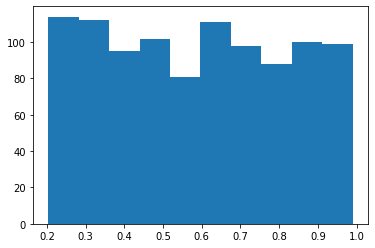

In [43]:
np.random.seed(42)
s = uniform(.2, .79).rvs(size=1000)
print(min(s))
print(max(s))
plt.hist(s)

2
99


(array([111., 105., 104.,  95.,  84., 112.,  98.,  89.,  83., 119.]),
 array([ 2. , 11.7, 21.4, 31.1, 40.8, 50.5, 60.2, 69.9, 79.6, 89.3, 99. ]),
 <BarContainer object of 10 artists>)

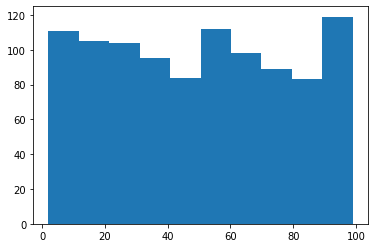

In [44]:
np.random.seed(42)
s = randint(2, 100).rvs(size=1000)
print(min(s))
print(max(s))
plt.hist(s)

In [ ]:
s = randint(2, 20)
s.

In [45]:
model_param_dict = [
    {
        'preparation__numeric_pipeline__impute_chooser__base_transformer': [SimpleImputer(strategy='mean')],
        'preparation__numeric_pipeline__scaling_chooser__base_transformer': [MinMaxScaler(), StandardScaler()],
        'preparation__non_numeric_pipeline__encoder_chooser__base_transformer': [OneHotEncoder(),
                                                                                 hlp.sklearn.CustomOrdinalEncoder()],
        'model__n_estimators': randint(50, 5000),
        # If float, then max_features is a fraction and round(max_features * n_features) features are considered at each split.
        'model__max_features':  uniform(.01, .99),
    },
]

In [46]:
num_folds = 5
num_repeats = 2

In [48]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
random_search = RandomizedSearchCV(estimator=full_pipeline,
                                 param_distributions=model_param_dict,
                                 n_iter=30,
                                 cv=RepeatedKFold(n_splits=num_folds, n_repeats=num_repeats),
                                 scoring='roc_auc',
                                 #return_train_score=True,
                                 n_jobs=-1,
                                 #verbose=2,
                                 random_state=42,
                                )
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('preparation',
                                              ColumnTransformer(transformers=[('numeric_pipeline',
                                                                               Pipeline(steps=[('impute_chooser',
                                                                                                TransformerChooser()),
                                                                                               ('scaling_chooser',
                                                                                                TransformerChooser())]),
                                                                               ['duration',
                                                                                'credit_amount',
                                                                                'installment_commitme

In [49]:
random_search_df = hlp.sklearn.cv_results_to_dataframe(searcher=random_search,
                                                       num_folds=num_folds,
                                                       num_repeats=num_repeats,
                                                       return_style=False)

In [50]:
random_search_df.head()

,roc_auc Mean,roc_auc 95CI.LO,roc_auc 95CI.HI,model | max_features,model | n_estimators,preparation | non_numeric_pipeline | encoder_chooser | base_transformer,preparation | numeric_pipeline | impute_chooser | base_transformer,preparation | numeric_pipeline | scaling_chooser | base_transformer
1,0.773306,0.748196,0.798416,0.061119,2640,CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
8,0.771901,0.746830,0.796972,0.123688,4799,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
13,0.768995,0.744684,0.793306,0.096989,1392,OneHotEncoder(),SimpleImputer(),MinMaxScaler()
17,0.767660,0.743948,0.791371,0.133054,425,OneHotEncoder(),SimpleImputer(),MinMaxScaler()
20,0.764730,0.738600,0.790860,0.148375,922,OneHotEncoder(),SimpleImputer(),StandardScaler()


In [51]:
hlp.sklearn.cv_results_to_dataframe(searcher=random_search,
                                    num_folds=num_folds,
                                    num_repeats=num_repeats,
                                    return_style=True)

roc_auc Mean,roc_auc 95CI.LO,roc_auc 95CI.HI,model | max_features,model | n_estimators,preparation | non_numeric_pipeline | encoder_chooser | base_transformer,preparation | numeric_pipeline | impute_chooser | base_transformer,preparation | numeric_pipeline | scaling_chooser | base_transformer
0.773,0.748,0.798,0.061,"2,640",CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
0.772,0.747,0.797,0.124,"4,799",CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
0.769,0.745,0.793,0.097,"1,392",OneHotEncoder(),SimpleImputer(),MinMaxScaler()
0.768,0.744,0.791,0.133,425,OneHotEncoder(),SimpleImputer(),MinMaxScaler()
0.765,0.739,0.791,0.148,922,OneHotEncoder(),SimpleImputer(),StandardScaler()
0.765,0.739,0.790,0.182,"2,920",OneHotEncoder(),SimpleImputer(),MinMaxScaler()
0.763,0.737,0.790,0.208,"4,677",OneHotEncoder(),SimpleImputer(),StandardScaler()
0.763,0.737,0.789,0.213,"1,620",OneHotEncoder(),SimpleImputer(),StandardScaler()
0.760,0.734,0.786,0.240,"1,298",OneHotEncoder(),SimpleImputer(),MinMaxScaler()
0.759,0.736,0.782,0.339,"1,252",CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()


In [54]:
column = 'preparation | non_numeric_pipeline | encoder_chooser | base_transformer'
random_search_df.fillna(0).groupby(column).agg({'roc_auc Mean': np.mean}).sort_values(by='roc_auc Mean', ascending=False)

,roc_auc Mean
preparation | non_numeric_pipeline | encoder_chooser | base_transformer,
OneHotEncoder(),0.755248
CustomOrdinalEncoder(),0.749406


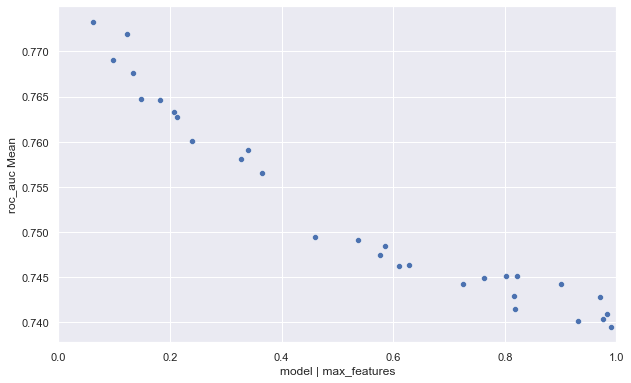

In [62]:
import matplotlib.pyplot as plt
plt.xlim(0, 1)
sns.set(rc={'figure.figsize': hlp.plot.STANDARD_WIDTH_HEIGHT})
sns.scatterplot(data=random_search_df, x="model | max_features", y="roc_auc Mean")
plt.show()

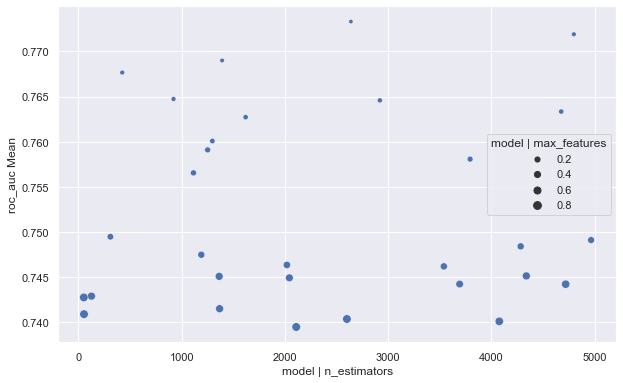

In [61]:
sns.set(rc={'figure.figsize': hlp.plot.STANDARD_WIDTH_HEIGHT})
sns.scatterplot(data=random_search_df,
                x="model | n_estimators",
                y="roc_auc Mean",
                size='model | max_features')
plt.show()

# TODO

- decide between imputing missing values and removing missing data; via tuning parameter(s)

- get feature importance for model that has various transformations
    - https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214
    - https://stackoverflow.com/questions/38787612/how-to-extract-feature-importances-from-an-sklearn-pipeline
   
```
grid_search.best_estimator_._final_estimator.feature_importances_
grid_search.best_estimator_._final_estimator.feature_importances_.shape
```

- future importance
    - https://www.kaggle.com/general/175075
        - LOFO (Leave one feature out) for feature importance.
    - https://explained.ai/rf-importance/